In [1]:
%load_ext autoreload
%matplotlib inline

%autoreload 2

from glob import glob
from dask.delayed import delayed
import dask.dataframe as dd
import pandas as pd
import numpy as np
from functools import reduce

import matplotlib.pylab as plt
plt.style.use('ggplot')

from utils import read_ngrams, save_ngrams

In [2]:
ARTICLES = [
    "article one",
    "article two",
    "article three",
    "article four",
    "article five",
    "article six",
    "article seven",
]

AMENDMENTS = [
    "first amendment",
    "second amendment",
    "third amendment",
    "fourth amendment",
    "fifth amendment",
    "sixth amendment",
    "seventh amendment",
    "eighth amendment",
    "ninth amendment",
    "tenth amendment",
    "eleventh amendment",
    "twelfth amendment",
    "thirteenth amendment",
    "fourteenth amendment",
    "fifteenth amendment",
    "sixteenth amendment",
    "seventeenth amendment",
    "eighteenth amendment",
    "nineteenth amendment",
    "twentieth amendment",
    "twenty-first amendment",
    "twenty-second amendment",
    "twenty-third amendment",
    "twenty-fourth amendment",
    "twenty-fifth amendment",
    "twenty-sixth amendment",
    "twenty-seventh amendment",
]

QUERIES = ARTICLES + AMENDMENTS

In [3]:
REMAINDER_COLS = ['r1', 'r2', 'r3']

def load_data(glob):
    df = read_ngrams(glob)
    df = df.compute()
    df['ngram'] = df['ngram'].str.lower()

    # augment with query data
    df = df.merge(
        pd.DataFrame({q: df['ngram'].str.contains(r'\b' + q + r'\b', regex=True) for q in QUERIES}),
        left_index=True,
        right_index=True
    )

    # filter for single exact word match
    df[df[QUERIES].sum(axis=1) == 1]  # single match only

    # add query in
    for q in QUERIES:
        df.loc[df[q], 'query'] = q

    # augment with individual words
    word_cols = ['w{:d}'.format(i) for i in range(5)]
    df = df.merge(
        pd.DataFrame.from_records(
            df['ngram'].str.split(' ').values,
            index=df.index,
            columns=word_cols
        ),
        left_index=True,
        right_index=True
    )

    # augment with remainders
    for r in REMAINDER_COLS:
        df.loc[:, r] = ''
    df[REMAINDER_COLS] = ''

    for q in QUERIES:
        df.loc[df[q], REMAINDER_COLS] = df.loc[df[q], 'ngram'].str.replace(q, '').str.strip().str.extract('(\S+)\s+(\S+)\s+(\S+)').values
        
    return df

df_raw = load_data("/mnt/volume_sfo2_03/downloads/google_ngrams/5/constitution-sample-gz/part-*")


In [4]:
df = pd.concat([
    df_raw[[w, 'query', 'year', 'total', 'distinct']].rename({w: 'w'}, axis=1)
    for w in REMAINDER_COLS
]).groupby(['w', 'query', 'year']).sum().reset_index()

df.sample(10, random_state=42)

,w,query,year,total,distinct
22117,should,eighteenth amendment,1967,1,1
21713,sale,eighteenth amendment,1995,1,1
10581,constitution,eighteenth amendment,1931,72,60
5128,applicable,eighth amendment,2001,10,8
12066,either,fourteenth amendment,2004,4,4
23249,that,fifth amendment,1987,9,9
7671,arose,fourteenth amendment,1959,2,2
16973,ninth,tenth amendment,1983,5,5
9779,consistently,eighth amendment,1995,3,3
4894,and,tenth amendment,1968,1,1


In [5]:
df_ratios = (df.groupby(['w', 'query'])[['total', 'distinct']].sum() / (df.groupby(['w'])[['total', 'distinct']].sum() + 2)).reset_index()

def pad(x, n):
    return np.pad(x, (0, n-len(x)), 'constant', constant_values=(np.nan, np.nan))

def nlargest(df, n):
    return pd.DataFrame({
        q: pad(x.nlargest(n, 'total')['w'].values, n)
        for q, x in df_ratios.sort_values(['query', 'total'], ascending=False).groupby('query')
    }).T.reindex(QUERIES)

nlargest(df_ratios, 8)


,0,1,2,3,4,5,6,7
article one,eight,name,8,authorize,fully,may,say,most
article two,uniform,73,yale,commercial,warranties,three,ucc,b
article three,geneva,four,act,times,treaty,two,this,section
article four,alone,leave,two,chapter,this,section,treaty,a
article five,chapter,treaty,this,federal,of,constitution,the,NaN
article six,soviet,charter,treaty,of,constitution,the,",",NaN
article seven,before,days,publication,treaty,as,or,of,constitution
first amendment,freedoms,areas,around,basic,their,concern,arena,protected
second amendment,arms,argue,did,argues,that,under,argument,argued
third amendment,arms,",",the,NaN,NaN,NaN,NaN,NaN


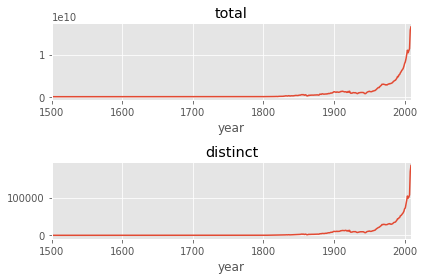

In [6]:
df_baseline = pd.read_csv("/mnt/volume_sfo2_02/googlebooks-eng-us-all-totalcounts-20120701.txt",
                          lineterminator='\t',
                          names=['year', 'total', 'page', 'distinct'])
_, axes = plt.subplots(nrows=2, ncols=1)
df_baseline.set_index('year')['total'].plot(ax=axes[0], title='total')
df_baseline.set_index('year')['distinct'].plot(ax=axes[1], title='distinct')
plt.tight_layout()


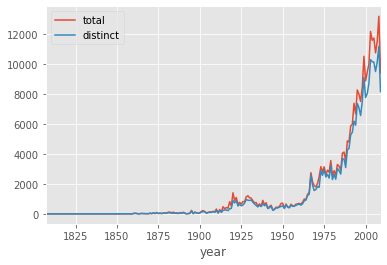

In [7]:
df.groupby(['year'])[['total', 'distinct']].sum().plot();

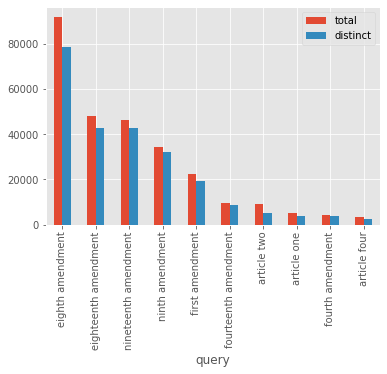

In [8]:
df_queries = (df.groupby(['query'])[['total', 'distinct']]
     .sum()
     .sort_values('total', ascending=False))

(df_queries.nlargest(10, 'total')
     .plot.bar());

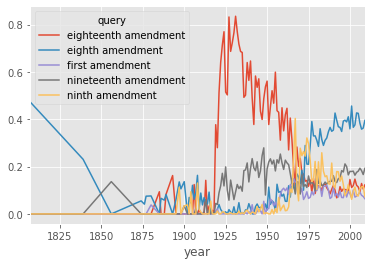

In [9]:
df_query_year = (
    df.groupby(['query', 'year'])[['total', 'distinct']].sum() /
    (df.groupby(['year'])[['total', 'distinct']].sum() + 10)
)

(df_query_year.loc[[q for q in QUERIES if q in df_queries.nlargest(5, 'total').index], :]
     .unstack('query')['total']
     .fillna(0)
     .sort_index()
     .plot())
